In [2]:
%pip install matplotlib pysimilar --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
from matplotlib import pyplot as plt
from pysimilar import compare

In [14]:
extraction_benchmark_path = "../extract_questions/results/benchmark_results.json"
if not os.path.exists(extraction_benchmark_path):
    raise FileNotFoundError("Please run the extraction benchmark first")

FileNotFoundError: Please run the extraction benchmark first

# Extractions

In [12]:
with open(extraction_benchmark_path, "r") as file:
    data_extraction = json.load(file)
    

{'fake_email_10.json': {'original_questions': [{'question': 'What are the English language requirements for my graduate programme?',
    'answer': "The English language requirements for a programme are stated on the programme's prospectus page. You may be required to meet one of UCL's five levels of English language proficiency, or obtain specific scores in a UCL-recognised test. UCL's English language policy details all of the ways in which you can meet the minimum English language requirement for your chosen programme of study.",
    'category': 'Entry requirements'},
   {'question': 'If my request to gain accreditation for prior learning is approved, what impact will this have on my studies at UCL?',
    'answer': 'If Recognition of Prior Learning (RPL) is approved this may impact on how your degree classification for your UCL programme of study is calculated. Credits accrued at UCL and awarded via RPL will be counted as part of the qualification requirements and included in the cal

## Number of originals vs number of extractions

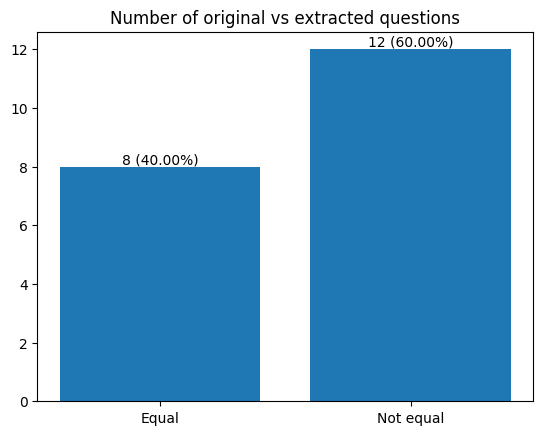

In [6]:
numbers_extracted = {}

for email in data_extraction["results"]:
    num_original =  len(data_extraction["results"][email]["original_questions"])
    num_extracted = len(data_extraction["results"][email]["extracted_questions"])
    numbers_extracted[email] = {
          "num_original": num_original,
          "num_extracted": num_extracted,
          "ratio": num_extracted / num_original,
          "equal": num_original == num_extracted
    }
    
# Plot equal and not equal
equal = [numbers_extracted[email]["equal"] for email in numbers_extracted]
not_equal = len(equal) - sum(equal)
plt.bar(["Equal", "Not equal"], [sum(equal), not_equal])
plt.title("Number of original vs extracted questions")

for i, v in enumerate([sum(equal), not_equal]):
    plt.text(i, v + 0.1, f"{v} ({v/len(equal)*100:.2f}%)", ha='center')
plt.show()

## Similarity scores

When the value is close to 0, the two texts are very different. When the value is close to 1, the two texts are very similar.

### All together

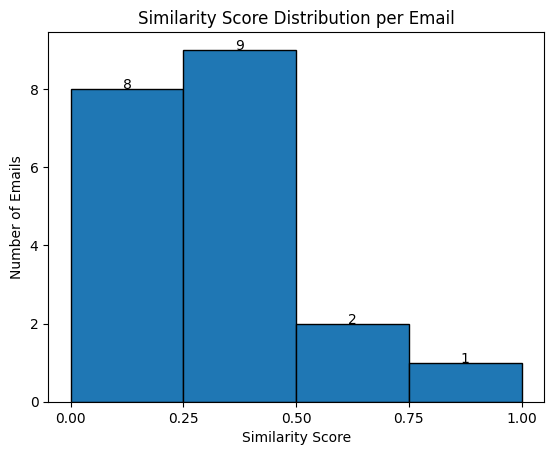

In [71]:
together_similarity_score = {}

for email in data_extraction["results"]:
    all_originals =  "\n ".join([question['question'] for question in data_extraction["results"][email]["original_questions"]])
    all_extracted = "\n ".join([question['question'] for question in data_extraction["results"][email]["extracted_questions"]])
    
    similarity_score = compare(all_originals, all_extracted)
    together_similarity_score[email] = similarity_score    

together_similarity_score
avg_similarity = sum(together_similarity_score.values()) / len(together_similarity_score)

bins = [0, 0.25, 0.5, 0.75, 1]
counts, _, _ = plt.hist(
    together_similarity_score.values(),
    bins=bins,
    edgecolor='black',
)
plt.title("Similarity Score Distribution per Email")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Emails")
plt.xticks(bins)

# Add number on top of each bar
for i, v in enumerate(counts):
    plt.text(bins[i] + 0.125, v, f"{int(v)}", ha='center')

plt.show()
    

### Per question 
*Taking the highest similarity score for each question*

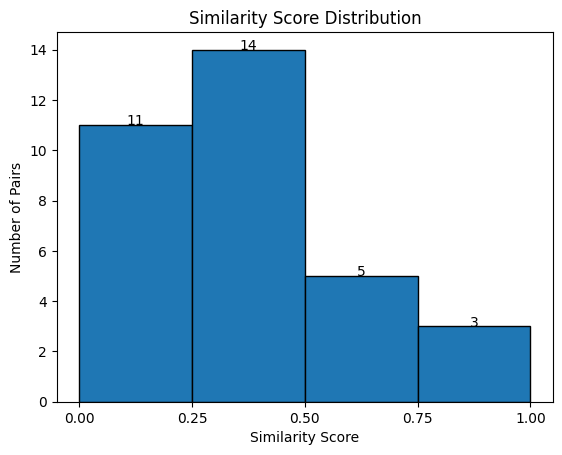

In [69]:
all_pairs = {}
for email in data_extraction["results"]:
    original_questions = [question['question'] for question in data_extraction["results"][email]["original_questions"]]
    extracted_questions = [question['question'] for question in data_extraction["results"][email]["extracted_questions"]]
    best_score = 0
    pairs = []
    for original_question in original_questions:
        for extracted_question in extracted_questions:
            score = compare(original_question, extracted_question)
            if score > best_score:
                best_score = score
                pairs.append({
                    "original": original_question,
                    "extracted": extracted_question,
                    "score": score
                })
                
    all_pairs[email] = pairs
    

bins = [0, 0.25, 0.5, 0.75, 1]

counts, _, _ = plt.hist(
    [pair["score"] for pairs in all_pairs.values() for pair in pairs],
    bins=bins,
    edgecolor='black',
)

plt.title("Similarity Score Distribution per question pair")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Pairs")
plt.xticks(bins)

for i, v in enumerate(counts):
    plt.text(bins[i] + 0.125, v, f"{int(v)}", ha='center')
    
plt.show()
  

# Time

Average time per question: 16.36 seconds
Average time per email: 15.66 seconds


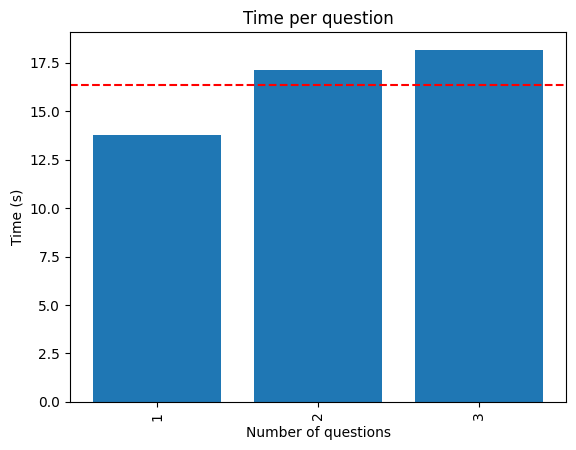

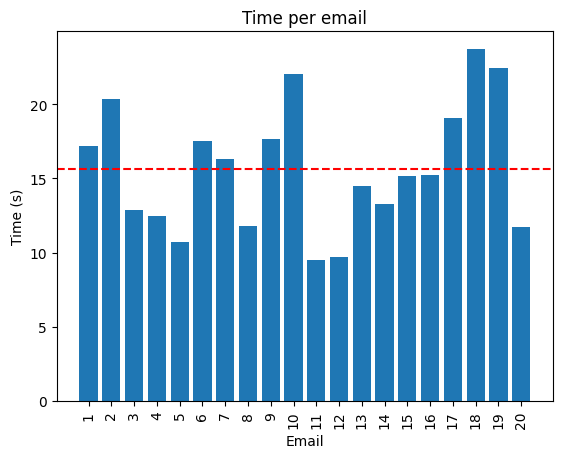

In [24]:
time_per_question = {}
quantity_per_question = {}
time_per_email = {}

for i, email in enumerate(data_extraction["results"]):
    time = data_extraction["results"][email]["extraction_time"]
    num_questions = len(data_extraction["results"][email]["original_questions"])
    time_per_question[num_questions] = time_per_question.get(num_questions, 0) + time
    quantity_per_question[num_questions] = quantity_per_question.get(num_questions, 0) + 1
    time_per_email[i+1] = time
        
time_per_question = {k: v / quantity_per_question[k] for k, v in time_per_question.items()}

avg_time_per_question = sum(time_per_question.values()) / len(time_per_question)
avg_time_per_email = sum(time_per_email.values()) / len(time_per_email)

print(f"Average time per question: {avg_time_per_question:.2f} seconds")
print(f"Average time per email: {avg_time_per_email:.2f} seconds")

plt.bar(time_per_question.keys(), time_per_question.values())
plt.axhline(y=avg_time_per_question, color='r', linestyle='--')
plt.title("Time per question")
plt.ylabel("Time (s)")
plt.xlabel("Number of questions")
plt.xticks(list(time_per_question.keys()), list(time_per_question.keys()), rotation=90)
plt.show()

plt.bar(time_per_email.keys(), time_per_email.values())
plt.axhline(y=avg_time_per_email, color='r', linestyle='--')
plt.title("Time per email")
plt.ylabel("Time (s)")
plt.xlabel("Email")
plt.xticks(list(time_per_email.keys()), list(time_per_email.keys()), rotation=90)
plt.show()


